In [1]:
import pandas as pd
import numpy as np
import sklearn
import sys
import os
import torch
import warnings
import random
import lightgbm as lgb
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from ruptures import Binseg
warnings.filterwarnings('ignore')

sys.path.append('../')
sys.path.append('../../')

from sklearn.linear_model import LogisticRegression
from snorkel.labeling.model import LabelModel

from src.data_util import load_wrench_dataset, load_LF
from src.metrics import exp_eval
from sklearn.model_selection import train_test_split

def get_baseline_pseudolabel(L, seed=123, y_train=None):
    
    label_model = LabelModel(cardinality=2, verbose=False)
    label_model.fit(L_train=L,
                    n_epochs=1000, log_freq=100, seed=seed)
    y_train_pseudo = label_model.predict(L, tie_break_policy="random")  
    
    return y_train_pseudo


class DNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=32, output_dim=2):
        super(DNN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    
    def get_last_layer_activation(self, x):
        for layer in self.layers[:-1]:
            x = layer(x)
        return x

def train_dnn(X, y, X_test, y_test, epochs=10, batch_size=32, verbose=False):
    # Remove scaling
    X_tensor = torch.FloatTensor(X)
    y_tensor = torch.LongTensor(y)
    X_test_tensor = torch.FloatTensor(X_test)
    
    dataset = TensorDataset(X_tensor, y_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    model = DNN(input_dim=X.shape[1])
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())
    
    for epoch in tqdm(range(epochs)):
        model.train()
        loss_sum = 0
        for batch_X, batch_y in dataloader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            loss_sum += loss.item()

        if verbose:
            print(f'Epoch {epoch+1}, Loss: {loss_sum/len(dataloader)}')

    model.eval()
    with torch.no_grad():
        y_pred = model(X_test_tensor).argmax(dim=1).numpy()
    if verbose:
        print('y_pred, y_test', y_pred, y_test, np.sum(y_pred), np.sum(y_test), np.sum(y_pred == y_test))
    return model, accuracy_score(y_test, y_pred)

def get_dnn_last_layer_activation(model, X):
    X_tensor = torch.FloatTensor(X)
    
    model.eval()
    with torch.no_grad():
        activations = model.get_last_layer_activation(X_tensor).numpy()
    
    return activations

100%|██████████| 11/11 [00:08<00:00,  1.36it/s]


{'dataset_name': 'basketball', 'seed': 0, 'lm_acc': 0.6375069560378408, 'gt_acc': 0.8993453355155483, 'acc_list': [0.5867430441898527, 0.8297872340425532, 0.42635024549918166, 0.10065466448445172, 0.10065466448445172, 0.10965630114566285, 0.10065466448445172, 0.9009819967266776, 0.10065466448445172, 0.10638297872340426, 0.10065466448445172], 'overlap_avg_acc': 0.5, 'overlap_avg_confidence': 0.30252761857881133, 'nonoverlap_avg_acc': 0.6377215472076692, 'nonoverlap_avg_confidence': 0.3387140106400738}


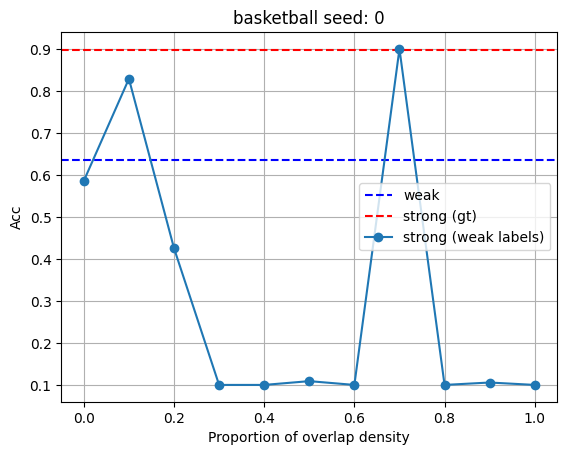

  0%|          | 0/11 [00:00<?, ?it/s]

In [2]:

verbose = False
dataset_name_list =  ['basketball', 'cdr', 'census', 'commercial', 'imdb', 'mushroom', 'sms', 'spambase', 'tennis', 'yelp', 'youtube']
data_base_path = '/home/changho/datasets'
df_result = []
for seed in range(25):
        
    for dataset_name in dataset_name_list:
        try:
                
            x_train, y_train, x_test, y_test = load_wrench_dataset(dataset_name=dataset_name,
                                                                data_base_path=data_base_path)

            scaler = StandardScaler()
            x_train = scaler.fit_transform(x_train)
            x_test = scaler.transform(x_test)
            indices_train = np.arange(len(x_train))
            weak_train_indices, w2s_train_indices = train_test_split(indices_train, test_size=0.5,
                                                                    random_state=seed)
            
            x_weak_train, y_weak_train = x_train[weak_train_indices], y_train[weak_train_indices]
            x_w2s_train, y_w2s_train = x_train[w2s_train_indices], y_train[w2s_train_indices]

            L = load_LF(dataset_name, data_base_path=data_base_path)
            L_weak_train = L[weak_train_indices]
            L_w2s_train = L[w2s_train_indices]

            # Stage 1. Train Weak Label Model
            label_model = LabelModel(cardinality=2, verbose=False)
            label_model.fit(L_train=L_weak_train, n_epochs=1000, log_freq=100, seed=seed)

            # Stage 2. Separate hard points from easy or overlap points
            proba_w2s_train = label_model.predict_proba(L_w2s_train)[:, 1]
            confidence_w2s_train = 2*np.abs(proba_w2s_train - 0.5)


            # Get indices of points in the cluster with minimum center
            # Apply change point detection to decide threshold
            

            # Sort confidence scores
            sorted_confidence = np.sort(confidence_w2s_train)
            
            # Perform change point detection
            model = Binseg(model="l2").fit(sorted_confidence.reshape(-1, 1))
            change_points = model.predict(n_bkps=1)[0]
            
            # Use the detected change point as the threshold
            confidence_threshold = sorted_confidence[change_points]
            
            # Get indices of points below the threshold
            lower_confidence_indices = np.where(confidence_w2s_train <= confidence_threshold)[0]
            high_confidence_indices = np.where(confidence_w2s_train > confidence_threshold)[0]
            
            x_hard_points = x_w2s_train[lower_confidence_indices]
            L_hard_points = L_w2s_train[lower_confidence_indices]
            y_hard_points = y_w2s_train[lower_confidence_indices]

            x_easy_or_overlap = x_w2s_train[high_confidence_indices]
            L_easy_or_overlap = L_w2s_train[high_confidence_indices]
            y_easy_or_overlap = y_w2s_train[high_confidence_indices]

            # Train DNN on pseudolabeled dataset
            X_pseudolabeled = x_w2s_train
            y_pseudolabeled = label_model.predict(L_w2s_train, tie_break_policy="random")
            
            model_pseudo, _ = train_dnn(X_pseudolabeled, y_pseudolabeled, x_test, y_test, verbose=verbose)
            
            # Get activations for X_combined (which is x_easy_or_overlap)
            activations_easy_or_overlap = get_dnn_last_layer_activation(model_pseudo, x_easy_or_overlap)
            
            # Get activations for x_hard_points
            activations_hard_points = get_dnn_last_layer_activation(model_pseudo, x_hard_points)
            
            # Compute align scores using inner products of activations
            activations_easy_or_overlap_normalized = activations_easy_or_overlap / np.linalg.norm(activations_easy_or_overlap, axis=1, keepdims=True)
            activations_hard_points_normalized = activations_hard_points / np.linalg.norm(activations_hard_points, axis=1, keepdims=True)
            align_scores = np.abs(activations_easy_or_overlap_normalized @ activations_hard_points_normalized.T).mean(axis=1)
            
            
            # Apply change point detection to decide threshold for align scores
            sorted_align_scores = np.sort(align_scores)
            
            # Perform change point detection
            model = Binseg(model="l2").fit(sorted_align_scores.reshape(-1, 1))
            change_points = model.predict(n_bkps=1)[0]
            
            # Use the detected change point as the threshold
            align_score_threshold = sorted_align_scores[change_points]
            
            # Get indices of points above the threshold
            overlap_indices = np.where(align_scores >= align_score_threshold)[0]
            nonoverlap_indices = np.where(align_scores < align_score_threshold)[0]
            
            # Select the corresponding data points
            x_overlap = x_easy_or_overlap[overlap_indices]
            L_overlap = L_easy_or_overlap[overlap_indices]
            y_overlap_pseudo = label_model.predict(L_overlap, tie_break_policy="random")
            y_overlap = y_easy_or_overlap[overlap_indices]
            overlap_avg_acc = np.mean(y_overlap_pseudo == y_overlap)
            overlap_avg_confidence = np.mean(confidence_w2s_train[overlap_indices])

            x_nonoverlap = np.concatenate([x_hard_points, x_easy_or_overlap[nonoverlap_indices]])
            L_nonoverlap = np.concatenate([L_hard_points, L_easy_or_overlap[nonoverlap_indices]])
            y_nonoverlap_pseudo = label_model.predict(L_nonoverlap, tie_break_policy="random")
            y_nonoverlap = np.concatenate([y_hard_points, y_easy_or_overlap[nonoverlap_indices]])
            nonoverlap_avg_acc = np.mean(y_nonoverlap_pseudo == y_nonoverlap)
            nonoverlap_avg_confidence = np.mean(confidence_w2s_train[nonoverlap_indices])

            # weak model evaluation
            y_pred = label_model.predict(L_w2s_train, tie_break_policy="random")
            lm_acc = np.mean(y_pred == y_w2s_train)


            # Run mixing experiments
            acc_list = []
            wl_dataset_size = min(len(x_overlap), len(x_nonoverlap))
            w2s_train_indices = np.arange(len(x_w2s_train))
            w2s_train_sampled_indices = np.random.choice(w2s_train_indices, size=wl_dataset_size, replace=False)
            x_w2s_train_sampled = x_w2s_train[w2s_train_sampled_indices]
            y_w2s_train_sampled = y_w2s_train[w2s_train_sampled_indices]
            model, gt_acc = train_dnn(x_w2s_train_sampled, y_w2s_train_sampled, x_test, y_test, verbose=verbose)

            proportion_list = np.arange(0, 1.01, 0.1)
            overlap_indices_full = np.arange(len(x_overlap))
            nonoverlap_indices_full = np.arange(len(x_nonoverlap))
            for overlap_portion in tqdm(proportion_list):
                overlap_portion = np.round(overlap_portion, 1)
                nonoverlap_size = int(wl_dataset_size * (1-overlap_portion))
                overlap_size = int(wl_dataset_size * (overlap_portion))

                nonoverlap_indices = np.random.choice(nonoverlap_indices_full, size=nonoverlap_size, replace=False).tolist()
                overlap_indices = np.random.choice(overlap_indices_full, size=overlap_size, replace=False).tolist()
                
                sample_indices = nonoverlap_indices + overlap_indices
                random.shuffle(sample_indices)

                x_w2s = np.concatenate([x_nonoverlap[nonoverlap_indices], x_overlap[overlap_indices]])
                y_w2s = np.concatenate([y_nonoverlap_pseudo[nonoverlap_indices], y_overlap_pseudo[overlap_indices]])
                
                # Replace LGBMClassifier with train_dnn
                model, acc = train_dnn(x_w2s, y_w2s, x_test, y_test, verbose=verbose)
                acc_list.append(acc)

            result = {
                'dataset_name': dataset_name,
                'seed': seed,
                'lm_acc': lm_acc,
                'gt_acc': gt_acc,
                'acc_list': acc_list,
                'overlap_avg_acc': overlap_avg_acc,
                'overlap_avg_confidence': overlap_avg_confidence,
                'nonoverlap_avg_acc': nonoverlap_avg_acc,
                'nonoverlap_avg_confidence': nonoverlap_avg_confidence,
            }
            print(result)
            df_result.append(result)

            plt.axhline(y=lm_acc, color='b', linestyle='--', label='weak')
            plt.axhline(y=gt_acc, color='r', linestyle='--', label='strong (gt)')
            plt.plot(proportion_list, acc_list, 'o-', label='strong (weak labels)')
            plt.xlabel('Proportion of overlap density')
            plt.ylabel('Acc')
            plt.title(dataset_name+f' seed: {seed}')
            plt.legend()
            plt.grid()
            if not os.path.exists(f'figures/dnn_change_point_detection_with_hard_normalized'):
                os.makedirs(f'figures/dnn_change_point_detection_with_hard_normalized')
            plt.savefig(f'figures/dnn_change_point_detection_with_hard_normalized/{dataset_name}.pdf', dpi=300, bbox_inches='tight')
            plt.show()
        except:
            print(dataset_name, seed, 'failed')

df_result = pd.DataFrame(df_result)
df_result.to_csv('results/dnn_change_point_detection_with_hard_normalized.csv', index=False)

In [ ]:
dataset_name

In [ ]:
overlap_indices = np.where(align_scores >= align_score_threshold)[0]
nonoverlap_indices = np.where(align_scores < align_score_threshold)[0]
overlap_indices.shape, nonoverlap_indices.shape
        

In [ ]:
overlap_indices_full.shape, nonoverlap_indices_full.shape

In [ ]:
(activations_easy_or_overlap_normalized @ activations_hard_points_normalized.T)[0]

In [ ]:
activations_hard_points_normalized

In [ ]:
overlap_indices.shape